<a href="https://colab.research.google.com/github/smart-stats/ds4bio_book/blob/main/book/pytorch_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 

# Pytorch by example

This example from the pytorch documentation [here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html) displays generating random y ad x dat and fitting a multi-layer neural network. We're going to consider a regression problem, but using a two layer neural network to solve it. Consider something like this. We have 5 inputs; those get passed to 3 hidden nodes, those get RELU'd, which get passed to an output.

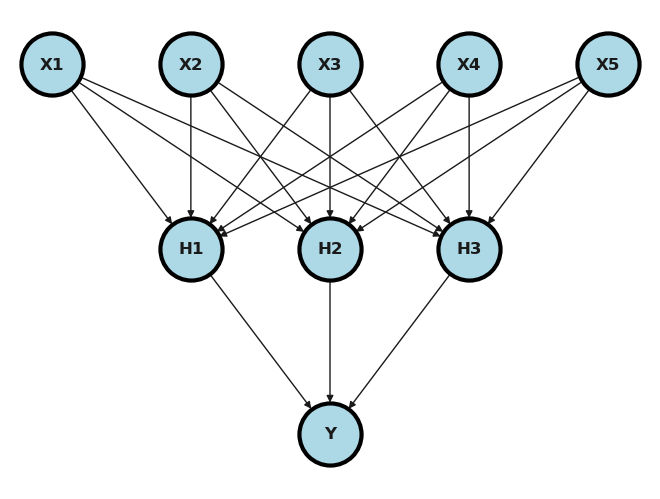

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl

#plt.figure(figsize=[2, 2])
G = nx.DiGraph()
G.add_node("X1",  pos = (0, 2) )
G.add_node("X2",  pos = (1, 2) )
G.add_node("X3",  pos = (2, 2) )
G.add_node("X4",  pos = (3, 2) )
G.add_node("X5",  pos = (4, 2) )

G.add_node("H1",  pos = (1, 1) )
G.add_node("H2",  pos = (2, 1) )
G.add_node("H3",  pos = (3, 1) )
G.add_node("Y" ,  pos = (2, 0) )

G.add_edges_from([ ("X1", "H1"), ("X2", "H1"), ("X3", "H1"),  ("X4", "H1"), ("X5", "H1")])
G.add_edges_from([ ("X1", "H2"), ("X2", "H2"), ("X3", "H2"),  ("X4", "H2"), ("X5", "H2")])
G.add_edges_from([ ("X1", "H3"), ("X2", "H3"), ("X3", "H3"),  ("X4", "H3"), ("X5", "H3")])
G.add_edges_from([ ("H1",  "Y"), ("H2",  "Y"), ("H3", "Y")])
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 2000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.3, 4.3])
ax.set_ylim([-.3, 2.3])
plt.show()

Below, we create an example. It isn't terribly interesting, since the X and the Y aren't related at all. But, it does show us some useful code.

In [12]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
sns.set()


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1000, 128, 32, 8

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

99 4534.51025390625
199 3433.26611328125
299 3105.7314453125
399 3059.81689453125
499 2737.764404296875
599 2601.751220703125
699 2479.807373046875
799 2429.35302734375
899 2493.08544921875
999 2565.323486328125


Let's update that example for our setting using the voxel level data.

In [13]:
## Read in the data and display a few rows
dat = pd.read_csv("https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv")

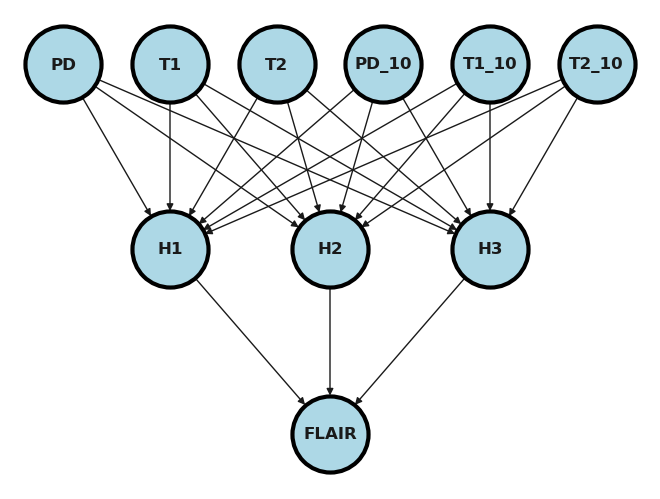

In [14]:
G = nx.DiGraph()
G.add_node("PD",     pos = (0, 2) )
G.add_node("T1",     pos = (1, 2) )
G.add_node("T2",     pos = (2, 2) )
G.add_node("PD_10",  pos = (3, 2) )
G.add_node("T1_10",  pos = (4, 2) )
G.add_node("T2_10",  pos = (5, 2) )

G.add_node("H1",  pos = (1.0, 1) )
G.add_node("H2",  pos = (2.5, 1) )
G.add_node("H3",  pos = (4.0, 1) )

G.add_node("FLAIR" ,  pos = (2.5, 0) )

G.add_edges_from([ ("PD", "H1"), ("T1", "H1"), ("T2", "H1"),  ("PD_10", "H1"), ("T1_10", "H1"), ("T2_10", "H1")])
G.add_edges_from([ ("PD", "H2"), ("T1", "H2"), ("T2", "H2"),  ("PD_10", "H2"), ("T1_10", "H2"), ("T2_10", "H2")])
G.add_edges_from([ ("PD", "H3"), ("T1", "H3"), ("T2", "H3"),  ("PD_10", "H3"), ("T1_10", "H3"), ("T2_10", "H3")])

G.add_edges_from([ ("H1",  "FLAIR"), ("H2",  "FLAIR"), ("H3", "FLAIR")])
nx.draw(G, 
        nx.get_node_attributes(G, 'pos'), 
        with_labels=True, 
        font_weight='bold', 
        node_size = 3000,
        node_color = "lightblue",
        linewidths = 3)
ax= plt.gca()
ax.collections[0].set_edgecolor("#000000")
ax.set_xlim([-.5, 5.5])
ax.set_ylim([-.3, 2.3])
plt.show()

Let's set the training fraction at 75% (and thus the testing fraction at 25%). This gives us relatively little data to fit with. Thus, a relatively simple model makes sense.

In [15]:
trainFraction = .75

sample = np.random.uniform(size = 100) < trainFraction
trainingDat = dat[sample]
testingDat = dat[~sample]


Next we need to get the data into a pytorch size and fram

In [16]:
x = torch.from_numpy(dat[['PD','T1', 'T2', 'T1_10', 'T2_10', ]].values)
y = torch.from_numpy(dat[['FLAIR']].values)

##pytorch wants type as float
x = x.float()
y = y.float()

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]

[
 xtraining.size(),
 ytraining.size(),
 xtesting.size(),
 ytesting.size(),
]

[torch.Size([76, 5]),
 torch.Size([76, 1]),
 torch.Size([24, 5]),
 torch.Size([24, 1])]

In [17]:
## Define the model
## Dimension of the hidden layer
H = 3

## Number of predictors
D_in = xtraining.size()[1]
D_out = 1

model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)



In [18]:
loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(100000):
    y_pred = model(xtraining)
    loss = loss_fn(y_pred, ytraining)
    if t % 10000 == 0:
        print(t, loss.item())
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad


0 171.88433837890625


10000 18.76696014404297
20000 16.824806213378906
30000 16.18133544921875
40000 16.068267822265625
50000 16.038101196289062
60000 16.03182601928711
70000 16.030363082885742
80000 16.029705047607422
90000 16.029869079589844


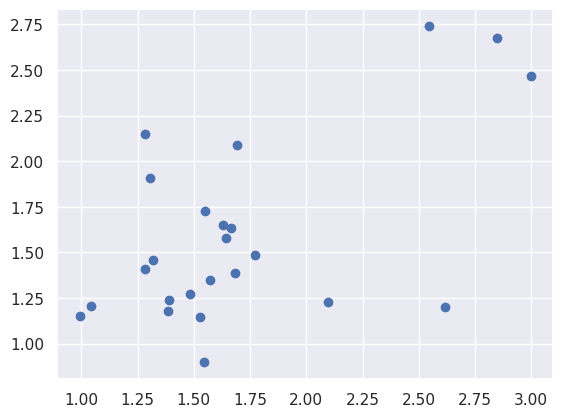

In [19]:
## try prediction
ytesting_pred = model(xtesting)
a = ytesting_pred.detach().numpy()

plt.scatter(a[:,0], ytesting[:,0]);